# PROBLEMA 5 LISTA 2

In [38]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from time import time
from datetime import timedelta
init_time = time()

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,  KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import set_config
from IPython.display import display, HTML

from yellowbrick.regressor import AlphaSelection

from statsmodels.genmod.generalized_linear_model import GLM
import statsmodels.api as sm
from scipy import stats

import warnings

set_config(display='text')
warnings.filterwarnings('ignore')

sns.set()
pd.set_option('display.precision', 3)

### CARGAR LOS DATOS

In [40]:
from ucimlrepo import fetch_ucirepo
import pandas as pd

try:
    dataset = fetch_ucirepo(id=544)
    data = pd.DataFrame(dataset.data['features'])
    print(dataset['variables'])

    target = pd.DataFrame(dataset.data['targets'], columns=["NObeyesdad"])

    full_data = pd.concat([data, target], axis=1)

except Exception as ex:
    print(ex)


                              name     role         type demographic  \
0                           Gender  Feature  Categorical      Gender   
1                              Age  Feature   Continuous         Age   
2                           Height  Feature   Continuous        None   
3                           Weight  Feature   Continuous        None   
4   family_history_with_overweight  Feature       Binary        None   
5                             FAVC  Feature       Binary        None   
6                             FCVC  Feature      Integer        None   
7                              NCP  Feature   Continuous        None   
8                             CAEC  Feature  Categorical        None   
9                            SMOKE  Feature       Binary        None   
10                            CH2O  Feature   Continuous        None   
11                             SCC  Feature       Binary        None   
12                             FAF  Feature   Continuous        

### VISUALIZACION DE LOS DATOS MINIMA

In [41]:
categorical_columns = list(full_data.dtypes[full_data.dtypes == 'O'].index.values)
print("Variables Categoricas:", categorical_columns)

print(full_data.columns)


tipos_variables = full_data.dtypes


valores_unicos = full_data.nunique()


resumen = pd.DataFrame({'Tipo': tipos_variables, 'Valores Únicos': valores_unicos})
print(resumen)


full_data.head()

Variables Categoricas: ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad']
Index(['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'CALC', 'MTRANS', 'NObeyesdad'],
      dtype='object')
                                   Tipo  Valores Únicos
Gender                           object               2
Age                             float64            1402
Height                          float64            1574
Weight                          float64            1525
family_history_with_overweight   object               2
FAVC                             object               2
FCVC                            float64             810
NCP                             float64             635
CAEC                             object               4
SMOKE                            object               2
CH2O                            floa

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


## APARTADO A

In [42]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

1


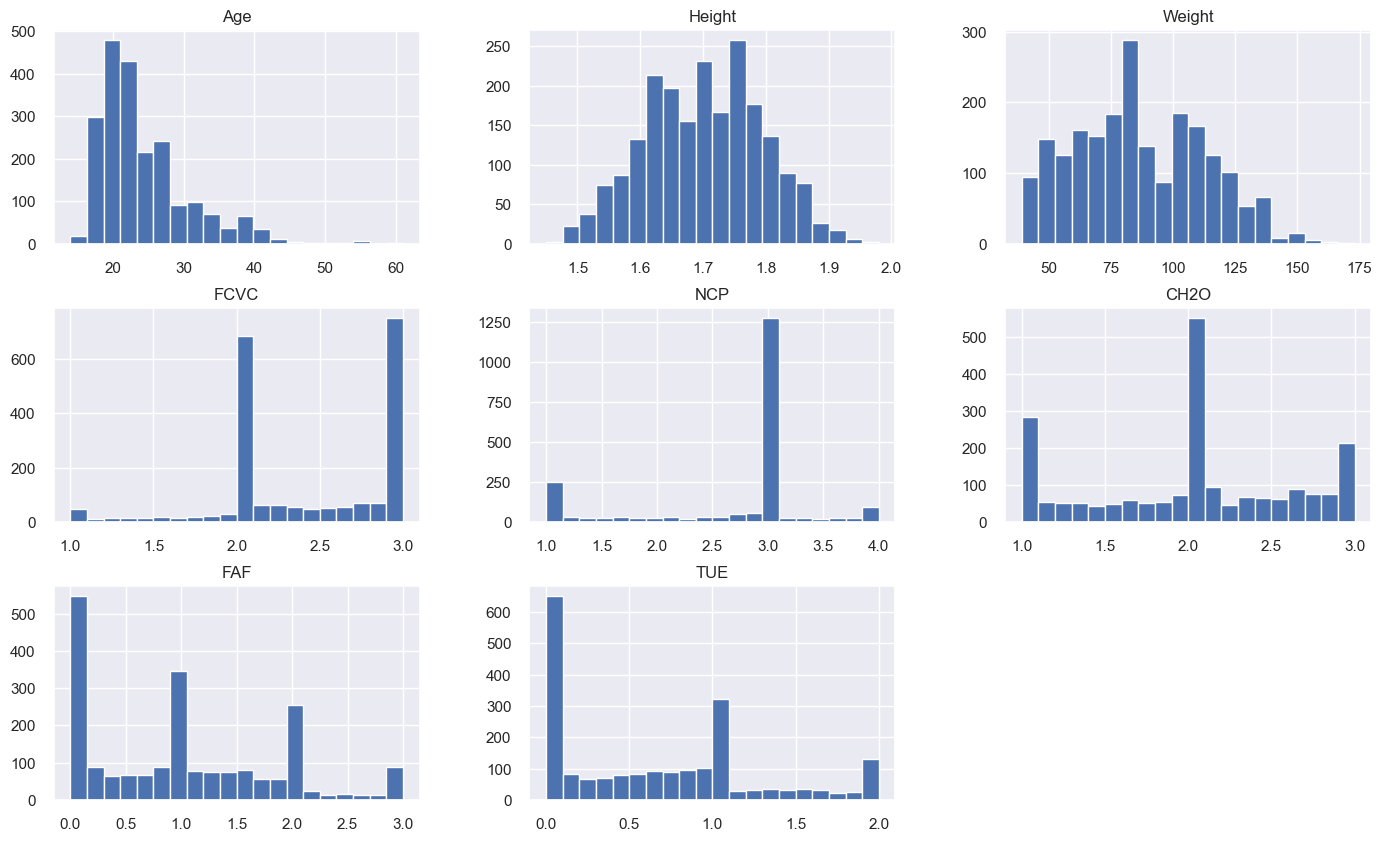

In [43]:
X = full_data.drop('NObeyesdad', axis=1)
y = full_data['NObeyesdad']

print(sum(X['CALC'] == "Always"))


X.hist(bins=20, figsize=(17,10));

Como observamos en los histogramas de arriba las variables numericas a excepción de el peso, la altura y puede que la edad no acaban de seguir una distribución normal o gausiana. Esto lo hemos de tener en cuenta para más adelante para que durante el proceso adaptemos los datos lo mejor posbile ya que entrenaremos un modelo naive bayes que asume la independendia de variables, asi como tambien assume una distribución normal. Vamos a ejecutar el normal test para saber cuanto de normales son nuestras variables.

In [44]:
from scipy.stats import normaltest

numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns

for col in numeric_cols:
  print(f"{col:20}: {normaltest(X[col], nan_policy='omit').pvalue:.10e}")

Age                 : 7.3701368137e-131
Height              : 7.2252254790e-13
Weight              : 1.9033493899e-29
FCVC                : 1.2912796136e-31
NCP                 : 2.1436327946e-66
CH2O                : 2.3608060855e-57
FAF                 : 4.3583954056e-34
TUE                 : 4.6309011092e-37


Como podemos observar, como todos los p-values de las variables son menores a 0.05, rechazaremos la hipótesis nula. Esto implica que nuestras variable numericas no siguen una distribución normla y tendremos que normalizarlas lo maximo que podamos más adelante para más tarde poder usar naive bayes lo mejor posible.

Para el preproceso aplicaremos OneHotEncoding a las diferentes variables categoricas y para las variables numericas aplicaremos yeo johnson para intentar que nuestros datos se acerquen lo maximo posible a una distribución normal.

In [45]:
from sklearn.preprocessing import PowerTransformer

def one_hot_encoding(X, scaler=None, columns=None):
    categorical_columns = X.dtypes[X.dtypes == 'object'].index.values
    numerical_columns = [c for c in X.columns if c not in categorical_columns]
    
    
    if scaler is None:
        scaler = PowerTransformer(method='yeo-johnson', standardize=True)
        X[numerical_columns] = scaler.fit_transform(X[numerical_columns])
    else:
        X[numerical_columns] = scaler.transform(X[numerical_columns])
    
    
    for c in categorical_columns:
        if X[c].nunique() == 2:
            
            X[c] = X[c].astype('category').cat.codes
        else:
            # Realizar one-hot encoding
            X_one_hot = pd.get_dummies(X[c], prefix=c, dtype=int)
            X = X.merge(X_one_hot, left_index=True, right_index=True)
            X = X.drop(columns=[c])
    
    # Si las columnas no están alineadas, agregamos las columnas faltantes a X
    if columns is not None:
        missing_cols = set(columns) - set(X.columns)
        for col in missing_cols:
            X[col] = 0  # Agregar las columnas faltantes con valores en cero
            
        # Reordenar las columnas para que coincidan con el conjunto original
        X = X[columns]
        
    return X, scaler


A continuación separaremos el conjunto de entrenamiento y test. Ademas aplicaremos el preproceso definido en la función de arriba que usara one hot encoding y yeo johnson.

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

X_train_scaled, scaler = one_hot_encoding(X_train)
X_test_scaled, _ = one_hot_encoding(X_test, scaler, X_train_scaled.columns)


X_train_scaled.T




,90,513,1100,339,612,1410,1921,1052,1572,65,...,1228,213,2072,1998,1178,1567,1336,609,1659,237
Gender,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,...,1.000,1.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,0.000
Age,0.440,-0.355,-0.981,-1.032,0.062,-1.065,0.590,1.397,0.983,-0.420,...,0.601,-0.420,-1.241,-0.343,-0.804,1.169,-0.417,-0.712,0.088,-1.032
Height,-0.772,-1.107,-0.036,-1.811,-1.244,-0.562,-0.864,0.306,1.202,-0.877,...,0.534,1.036,0.343,1.038,-0.028,0.864,1.647,0.535,1.571,-0.668
Weight,0.312,-1.765,-0.262,-1.917,-1.790,-0.103,0.738,-0.014,1.252,-0.632,...,0.841,-0.937,1.456,2.306,-0.260,1.260,1.180,-1.260,1.292,-1.355
family_history_with_overweight,0.000,0.000,1.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
FAVC,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,1.000,0.000,1.000,1.000,1.000,1.000,1.000
FCVC,1.140,1.140,-2.106,-0.873,-0.518,1.140,1.140,-0.873,1.063,-2.206,...,1.140,1.140,1.140,1.140,-1.410,0.043,-0.873,-0.873,1.140,1.140
NCP,2.520,-1.346,-0.497,0.302,-0.949,0.302,0.302,0.302,0.302,0.302,...,0.302,0.302,0.302,0.302,-0.111,0.302,0.302,1.284,-0.471,0.302
SMOKE,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
CH2O,-1.655,0.692,0.702,-1.655,0.147,-1.655,-0.622,0.290,0.838,-0.053,...,-0.420,-0.053,0.594,0.535,0.267,0.015,1.650,1.609,-0.557,-1.655


### Visualizacion de los datos

Si volvemos a visualizar los datos veremos que se han creado nuevas variable para aquellas categoricas con mas de 2 possibles valores. Y para las numericas hemos estandarizado los datos y yeo johnson ha ayudado a aproximar algunas variables a una distribuación gaussiana como la edad, la altura o el peso pero sin llegar a seguir dicha distribuación. Además siguen habiendo variables que no siguen ni de cerca una distribución normal. Si ejecutamos de nuevo el normal test, obtenemos los siguientes resultados:

In [47]:
for col in numeric_cols:
  print(f"{col:20}: {normaltest(X_train_scaled[col], nan_policy='omit').pvalue:.10e}")

Age                 : 2.0828495762e-19
Height              : 1.0031734410e-09
Weight              : 1.5571202812e-34
FCVC                : 0.0000000000e+00
NCP                 : 9.5110460235e-05
CH2O                : 4.7352826201e-32
FAF                 : 1.1897150740e-232
TUE                 : 0.0000000000e+00


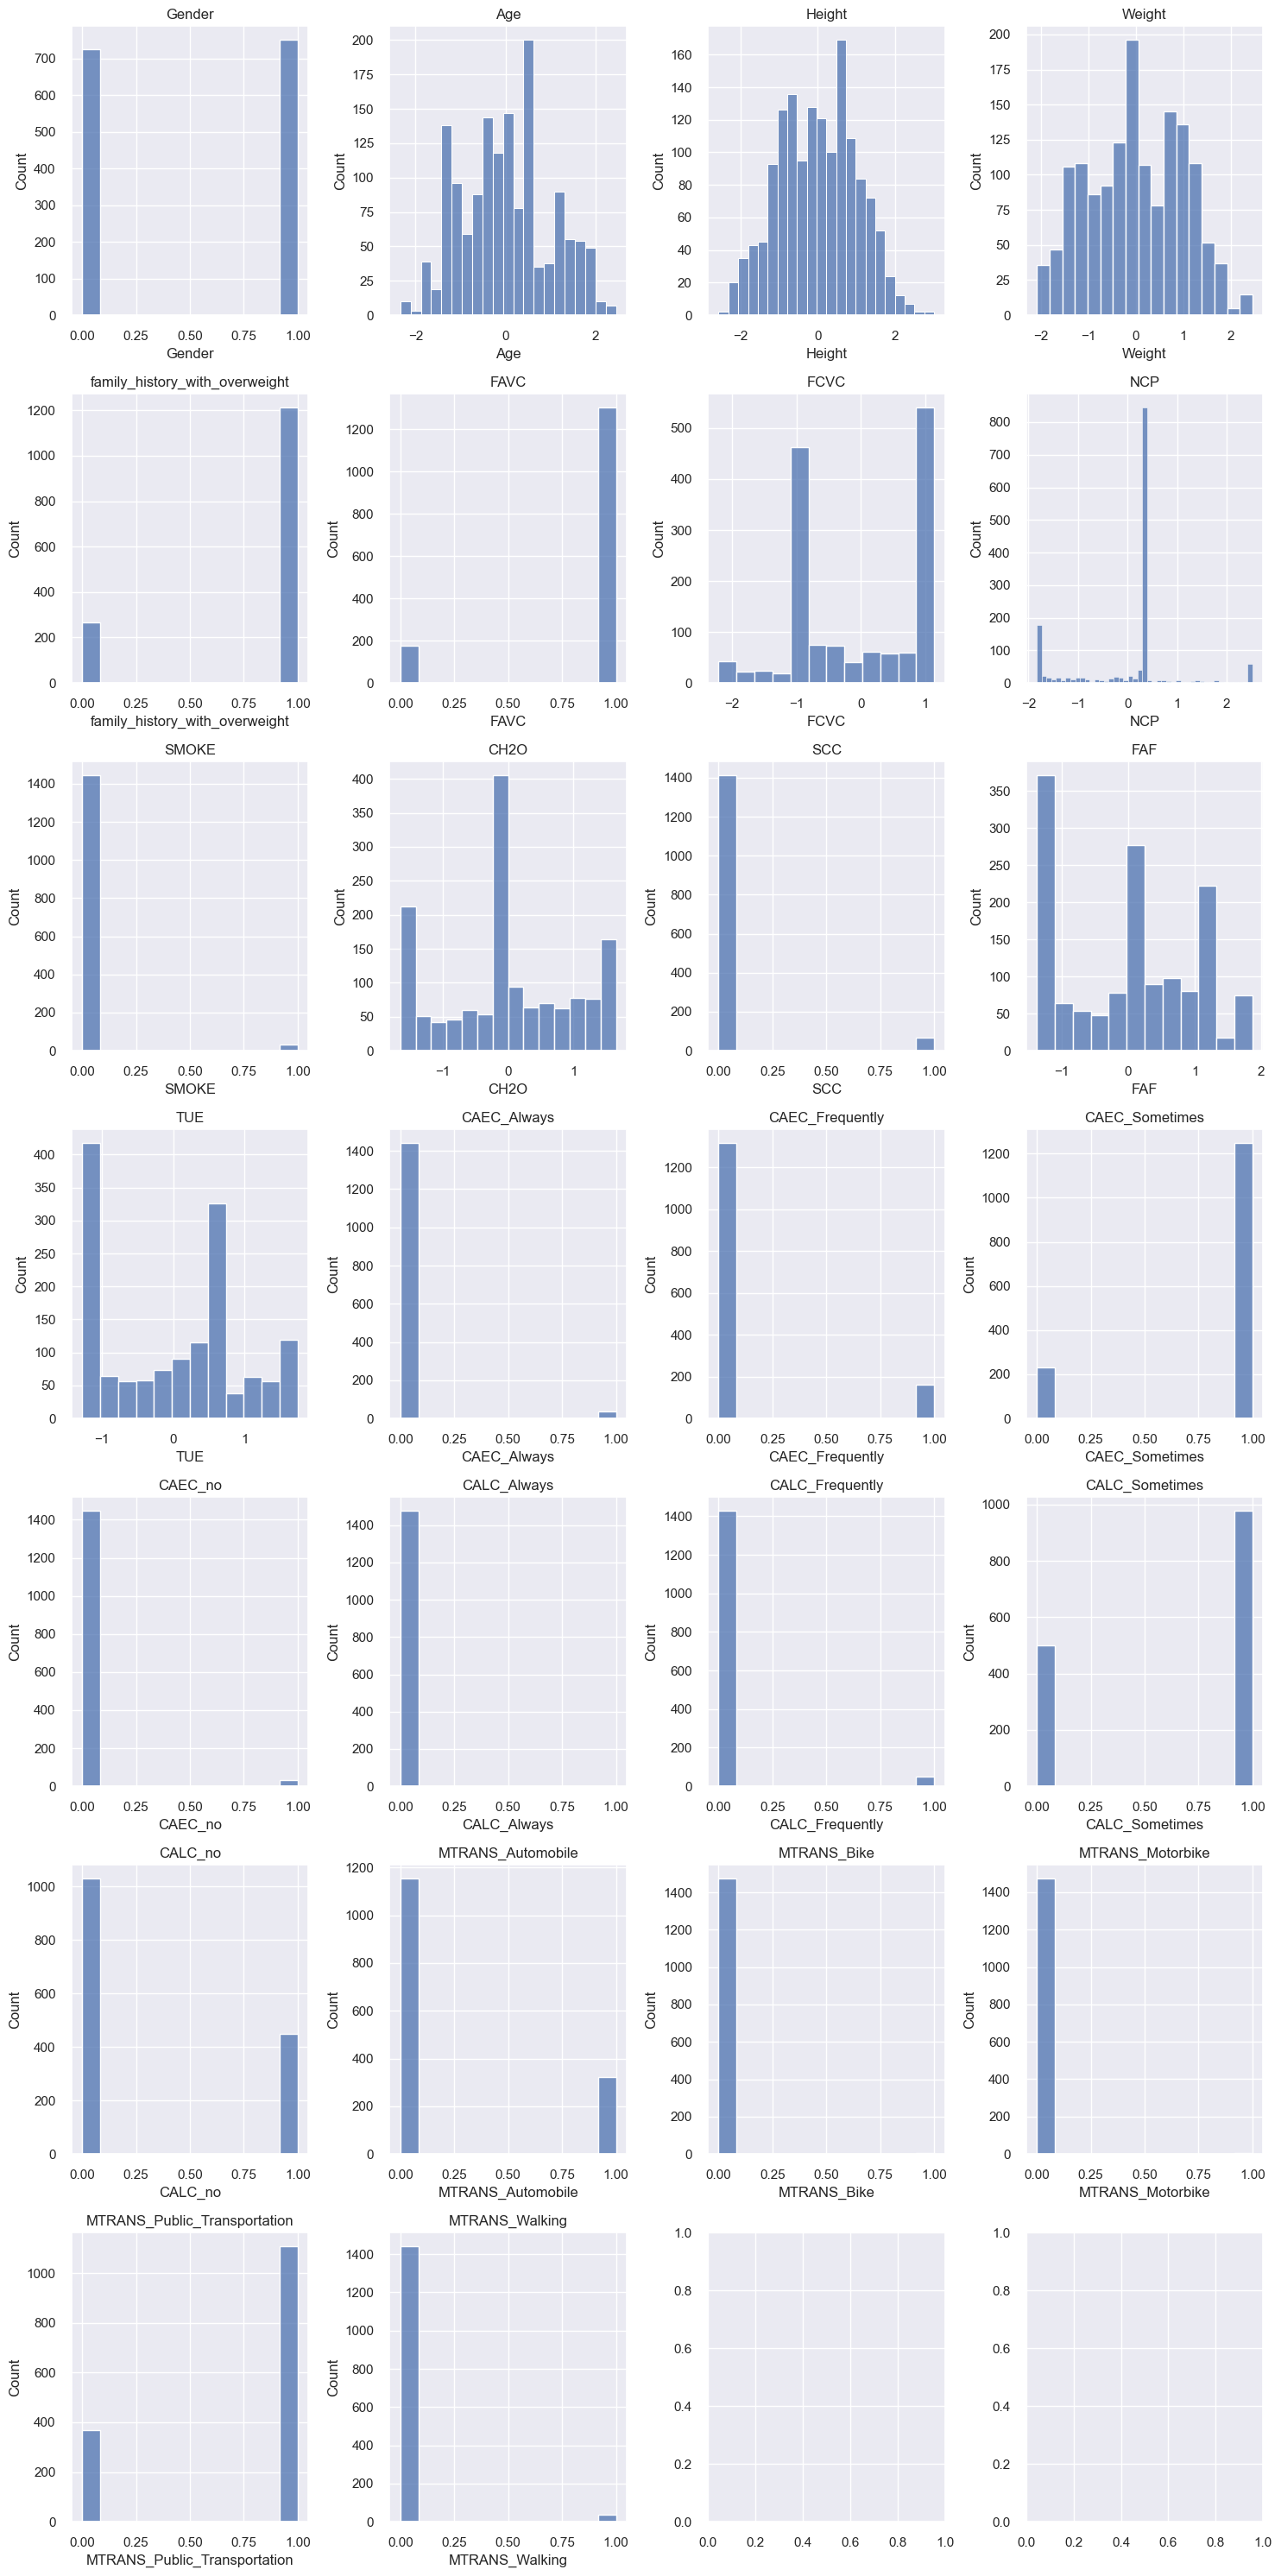

In [48]:
fig, axes = plt.subplots(7,4,figsize=(15,30))


for i, c in enumerate(X_train_scaled.columns):
    ax = axes.reshape(-1)[i]
    if X_train_scaled[c].dtype.kind == 'O':
        a = sns.countplot(x=c,data=X_train_scaled,ax=ax)
    else:
        b = sns.histplot(x=c,data=X_train_scaled,ax=ax)
    t = ax.set_title(c)
plt.tight_layout()

### CORRELACIONES

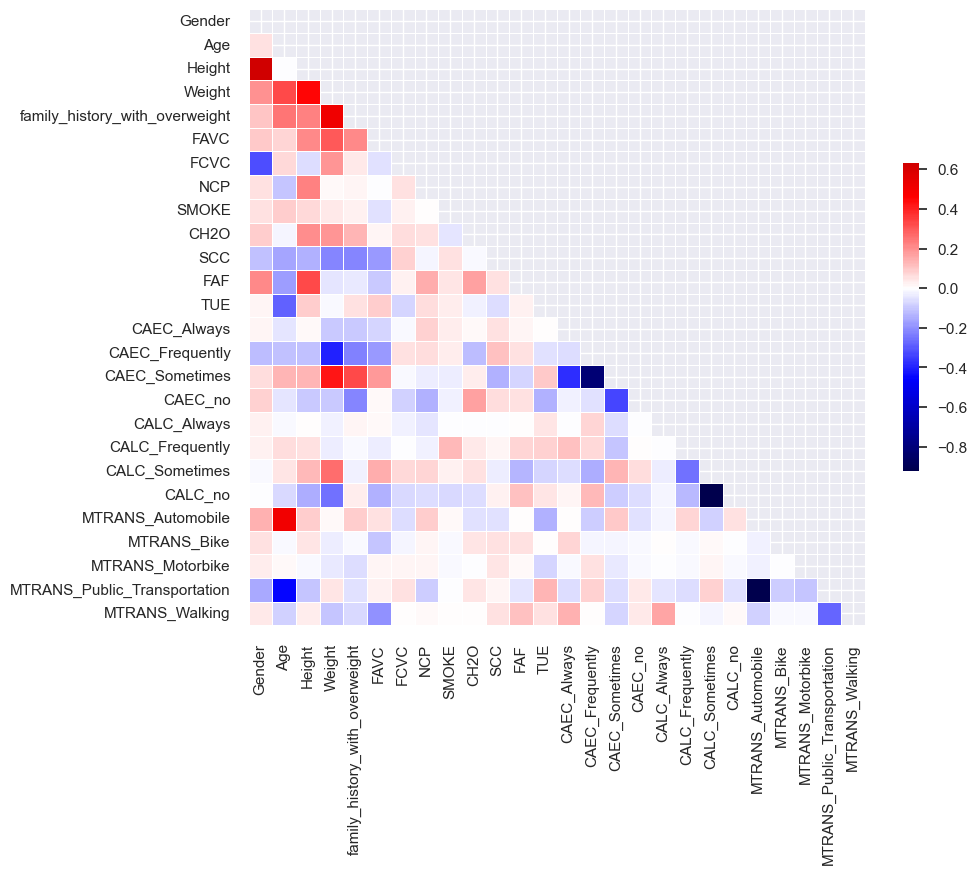

In [49]:
corr = X_train_scaled.corr(numeric_only=False)
mask = np.triu(np.ones_like(corr))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

Observando la matriz de correlaciones de las diferentes variables, observamos que no hay una grand cantidad de relaciones fuertes entre ellas. Las más destacadas que podemos encontrar son:
- El peso con si algun miembro de la familia tiene sobrepeso, el peso con la altura y la edad, el peso con CAEC_Sometimes que es la variable que nos dice si el individuo come de vez en cuando entre comidas.
- Por otro lado tenemos que el genero tiene una relación fuerte y positiva con la altura.
- Tambien podemos observar que las nuevas variables generadas a partir del one hot encoding tienen una relacion negativa con las de sus mismo grupo. Es decir con aquellas que se han generado a partir de la misma variable original, cosa que tiene sentido.

En resumen a primera vista las variables, excluyendo la objetivo que aun no la hemos visto, no tienen una relacion extremadamente fuerte entre ellas, cosa que nos vendra bien ya que naive bayes asume independencia entre las diferentes variables.

Vamos a hacer la matriz de correlaciones incluyendo la variable objetivo para comparar.

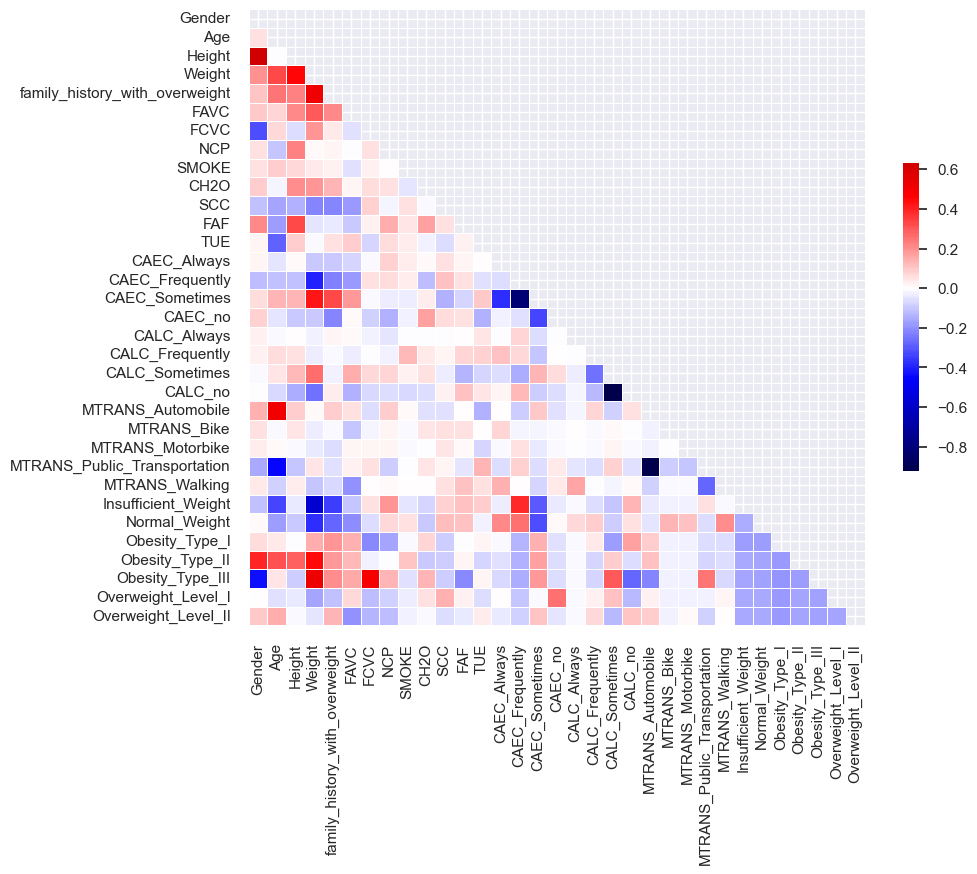

In [50]:
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot as plt

encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1, 1))

y_train_encoded_df = pd.DataFrame(y_train_encoded, columns=encoder.categories_[0], index=y_train.index)


train_encoded = pd.concat([X_train_scaled, y_train_encoded_df], axis=1)


correlation_matrix_encoded = train_encoded.corr()


mask = np.triu(np.ones_like(correlation_matrix_encoded))
plt.subplots(figsize=(10, 8))
sns.heatmap(correlation_matrix_encoded, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

Despues de usar oneHotEncoding para codificar la variable objetivo, nos han aparecido las siguientes nuevas variables:[Insufficient_Weight, Normal_Weight, Obesity_Type_I, Obesity_Type_II, Obesity_Type_III, Overweight_Level_I, Overweight_Level_II]. Vemos que entre ellas existe una correlación negativa, cosa que parece obvia ya que provienen todas de la misma variable original. Por otro lado tenemos que Obesity_Type_I tiene una fuerte relacioncon el genero, edad, altura, peso i si alguna familiar tiene sobrepeso. En cambio Obesity_Type_III tiene una relacion negativa bastante fuerte con el genero pero sigue manteniendo la relacion positiva con el peso y tiene una relacion positiva muy fuerte con FCVC que es la variable que describe si se comen vegetales o verduras en las comidas.

### PCA

En este apartado aplicaremos PCA

In [51]:
from sklearn.decomposition import PCA

myPCA = PCA().fit(X_train_scaled)

print(myPCA.explained_variance_ratio_)
print(myPCA.explained_variance_ratio_.cumsum())

[1.94619551e-01 1.67261893e-01 1.13564100e-01 1.08722623e-01
 9.88945744e-02 8.22288467e-02 6.88836995e-02 4.20004375e-02
 3.68128748e-02 2.15477076e-02 1.37780814e-02 1.16377998e-02
 9.84214347e-03 9.13936957e-03 4.94381518e-03 4.09214799e-03
 3.88494272e-03 3.09509245e-03 2.15587652e-03 2.00405090e-03
 5.05463231e-04 2.96155654e-04 8.87535696e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[0.19461955 0.36188144 0.47544554 0.58416817 0.68306274 0.76529159
 0.83417529 0.87617573 0.9129886  0.93453631 0.94831439 0.95995219
 0.96979433 0.9789337  0.98387752 0.98796966 0.99185461 0.9949497
 0.99710558 0.99910963 0.99961509 0.99991125 1.         1.
 1.         1.        ]


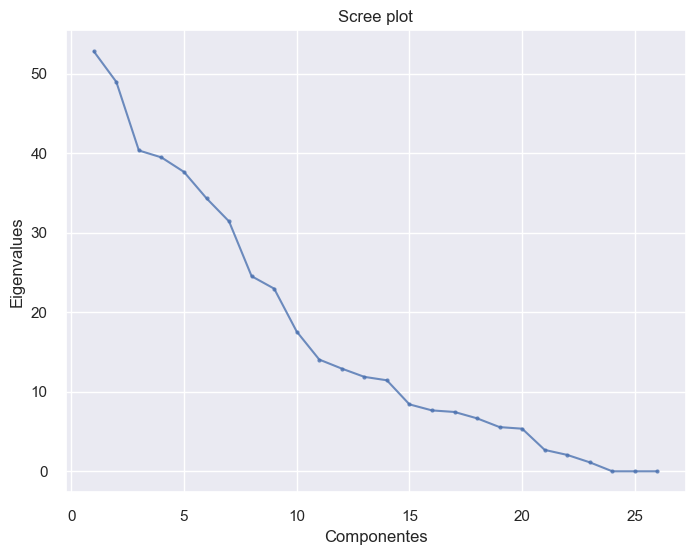

In [52]:
fig = plt.figure(figsize=(8,6));
plt.plot(range(1,len(myPCA.singular_values_ )+1),myPCA.singular_values_ ,alpha=0.8,marker='.');
y_label = plt.ylabel('Eigenvalues');
x_label = plt.xlabel('Componentes');
plt.title('Scree plot');

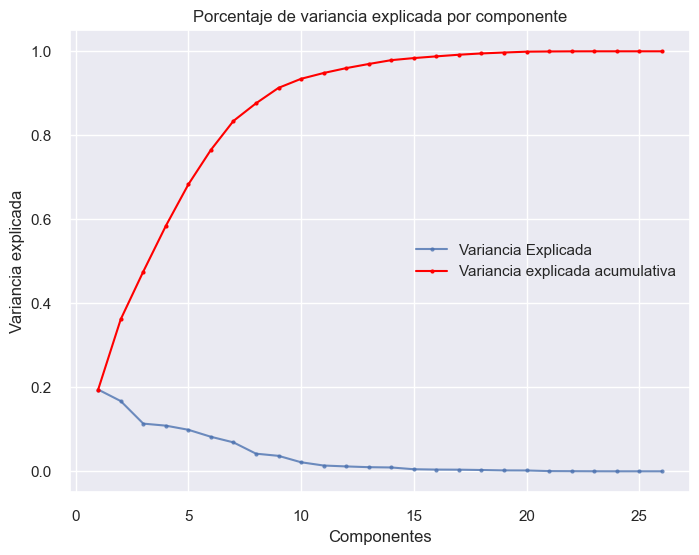

In [53]:
fig = plt.figure(figsize=(8,6));
plt.plot(range(1,len(myPCA.explained_variance_ratio_ )+1),myPCA.explained_variance_ratio_ ,alpha=0.8,marker='.',label="Variancia Explicada");
y_label = plt.ylabel('Variancia explicada');
x_label = plt.xlabel('Componentes');
plt.plot(range(1,len(myPCA.explained_variance_ratio_ )+1),
         np.cumsum(myPCA.explained_variance_ratio_),
         c='red',marker='.',
         label="Variancia explicada acumulativa");
plt.legend();
plt.title('Porcentaje de variancia explicada por componente');

Observando el grafico de la variancia explicada y de la variancia explicada acumulada, vemos que los dos primeros componentes ya explican alrededor del 50% de la variancia. A partir de los 6 o 7 componentes ya tenemos explicada alrededor del 80% de la variancia. Esta llega a concordar con los resultados de la matriz de correlaciones ya que como hemos dicho, no hay una relacion super fuerte entre variables diferentes, aunque en muchos casos la hay, pero por ejemplo, si observamos un grupo de variables con correlaciones altas, ya sean positivas o negativas (como las relacionadas con peso o con modos de transporte), estas podrían contribuir de manera similar a un único componente principal.

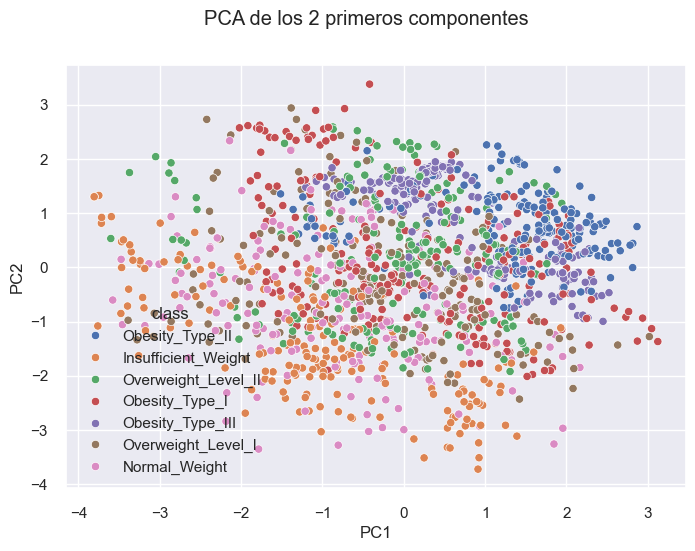

In [54]:
#PLOT 2D PCA
transformed_pca = myPCA.transform(X_train_scaled)

pca_data = pd.DataFrame({
    "PC1": transformed_pca[:,0],
    "PC2": transformed_pca[:,1],
    "class": y_train
})

_ = plt.suptitle("PCA de los 2 primeros componentes")
_ = sns.scatterplot(x="PC1", y="PC2", hue="class", data=pca_data)

En el grafico de los dos primeros componentes no podemos observar una gran separabilidad de las diferentes clases. Vemos que hay clases como Obesity_Type_II(azul) o Insuffiecient_Weight(naranja) que se situan sobretodo en la parte mas externa de la nube de puntos. Pero ademas de esto en general no podemos separar bien las clases, estan todos los puntos bastante mezclados. Vamos a intentar visualizar los datos usando TSNE para ver si obtenemos mejores resultados.

<Axes: xlabel='TSNE1', ylabel='TSNE2'>

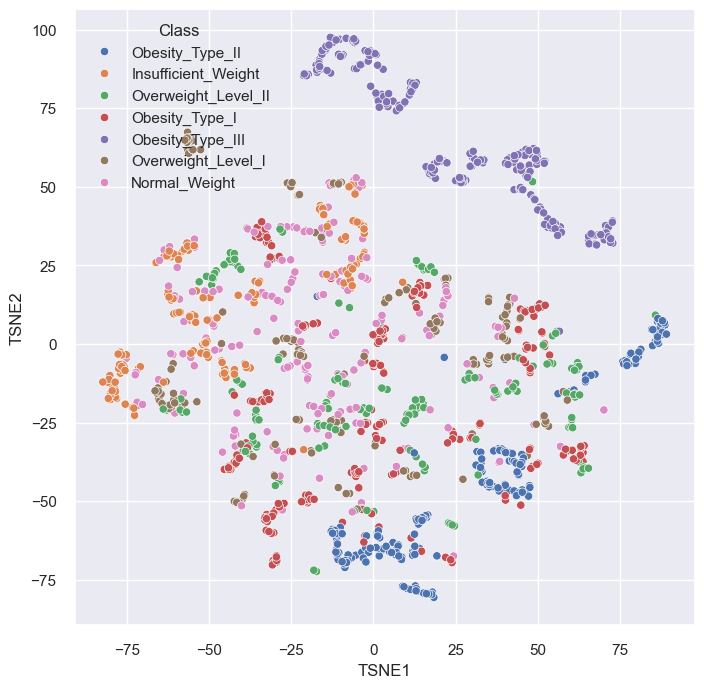

In [55]:
from sklearn.manifold import TSNE

data_tsne = pd.DataFrame(TSNE(n_components=2, perplexity=10,n_iter=2000, init='random').fit_transform(X_train_scaled), columns=['TSNE1','TSNE2'])
data_tsne['Class'] = y_train.values

fig = plt.figure(figsize=(8,8))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='Class', data=data_tsne)

Con TSNE vemos una mejor separabilidad de las clases. Observamos a muchos grupos pequeños que contienen concentraciones de individuos de la misma clase. Vemos que aun hay ciertas clases que se mezclan como por ejemplo: la naraja y la rosa, la marron con la verde y roja...

## APARTADO B

Usaremos la variante de Naive Bayes Gaussiano para datos continuos. Aunque los datos incluyen variables binarias, este método es adecuado

### NAIVE BAYES

In [56]:
import matplotlib.pyplot as plt
from matplotlib import colormaps
import numpy as np
from scipy import stats
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

def calc_ci(cv_fold_metrics):
    # Calcular parámetros para el ic
    cv_mean = np.mean(cv_fold_metrics)
    cv_sem = stats.sem(cv_fold_metrics)
    cv_folds = len(cv_fold_metrics)
    
    # Calculamos el intervalo de confianza del 95% con la distribución t student
    ci = stats.t.interval(
        confidence=0.95,
        df=cv_folds - 1,
        loc=cv_mean,
        scale=cv_sem
    )
    
    return cv_mean, ci

def show_results(results, model_name):
    """Función para mostrar los resultados de cross_validate."""
    
    # Detectar métricas usadas
    metrics = [name for name in results if "test_" in name]
    
    fig = plt.figure()
    ax = plt.gca()
    fig.suptitle(f"""Métricas del modelo "{model_name}" con IC del 95% para los valores de CV""")
    colors = colormaps["Set1"].colors
    ax.set_xticks(range(len(metrics)), [metric.split("_", 1)[1] for metric in metrics])
    ax.tick_params(axis='x', labelrotation=90)
    
    for (index, metric), color in zip(enumerate(metrics), colors):
        cv_mean, ci = calc_ci(results[metric])
        ax.scatter(index, cv_mean, marker='o', c=color, label="CV mean")
        ax.errorbar(index, cv_mean, yerr=[[cv_mean - ci[0]], [ci[1] - cv_mean]], c=color)
            
    plt.tight_layout()
    plt.show()

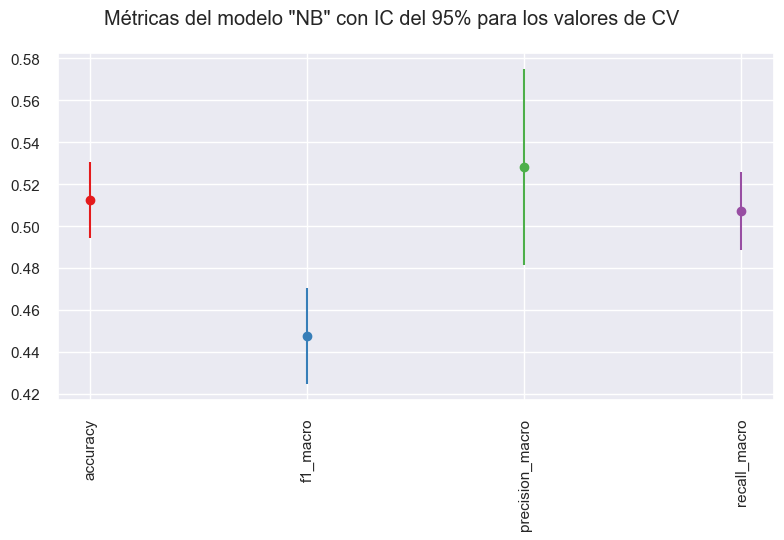

In [57]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_validate

nb = GaussianNB()

results = cross_validate(nb, X_train_scaled, y_train, cv=10, scoring=["accuracy", "f1_macro", "precision_macro", "recall_macro"])

show_results(results, "NB")

Podemos ver que los resultados de naive bayes son bastante malos, tenemos un accuracy en torno al 0.52, un f1 de 0.45 y una precision i recall similares al accuracy. Esto puede ser debido que hemos asumido que las variables son independientes y que ademas seguian una distribucion normal, cosa que hemos visto al principio de todo que no era cierto.

In [58]:
from sklearn.metrics import classification_report
print("X_train columns:", X_train_scaled.columns.size)
print("X_test columns:", X_test_scaled.columns.size)



y_test.value_counts()

labels = ["IW", "NW", "OT1", "OT2", "OT3", "OL1", "OL2"]
nb.fit(X_train_scaled, y_train)

print(classification_report(y_test, nb.predict(X_test_scaled)))

X_train columns: 26
X_test columns: 26


NObeyesdad
Obesity_Type_I         106
Obesity_Type_III        97
Obesity_Type_II         89
Overweight_Level_I      87
Overweight_Level_II     87
Normal_Weight           86
Insufficient_Weight     82
Name: count, dtype: int64

GaussianNB()

                     precision    recall  f1-score   support

Insufficient_Weight       0.50      0.71      0.58        82
      Normal_Weight       0.38      0.07      0.12        86
     Obesity_Type_I       0.49      0.47      0.48       106
    Obesity_Type_II       0.37      0.93      0.53        89
   Obesity_Type_III       1.00      0.99      0.99        97
 Overweight_Level_I       0.32      0.26      0.29        87
Overweight_Level_II       0.33      0.02      0.04        87

           accuracy                           0.50       634
          macro avg       0.48      0.49      0.43       634
       weighted avg       0.49      0.50      0.44       634



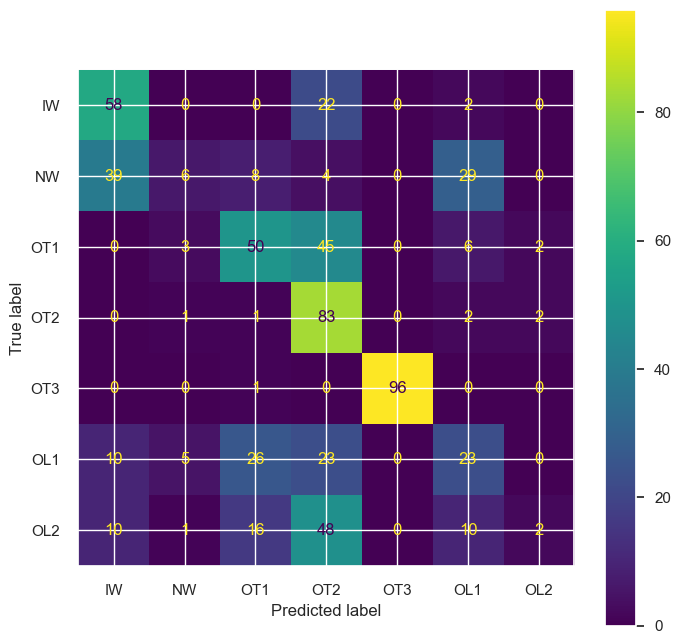

In [59]:
from sklearn.metrics import ConfusionMatrixDisplay


plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(nb, X_test_scaled,y_test, display_labels=labels, ax=plt.subplot());

El modelo tiene un buen desempeño en algunas clases (como Obesity_Type_III), pero en otras clases muestra un rendimiento muy bajo (por ejemplo, en Normal_Weight y Overweight_Level_II). Esto podria sugerir que hay un posible desbalance entre las diferentes clases o que no acaba de manejar bien ciertos grupos de datos. Vemos que obesity type 3 es la que mejor se predice, acertando todas sus instancias. Vemos que en los resultados se suele confundir la obesidad de nivel 1 con la obesidad de nivel 2. Tambien hay bastantes confusiones entre las obesidades de tipo 1 y 2 y el sobrepeso de nivel 1 y 2. En conclusion podriamos decir que tenemos unos resultados muy pobres, vemos que en el conjunto de entrenamiento los resultados de las metricas ya eran muy malos. Lo unico que nos ha confirmado la prediccion con el conjunto de test es que sigue la tendencia del set de entrenamiento.



## Discriminante Lineal

0.9146764111049824


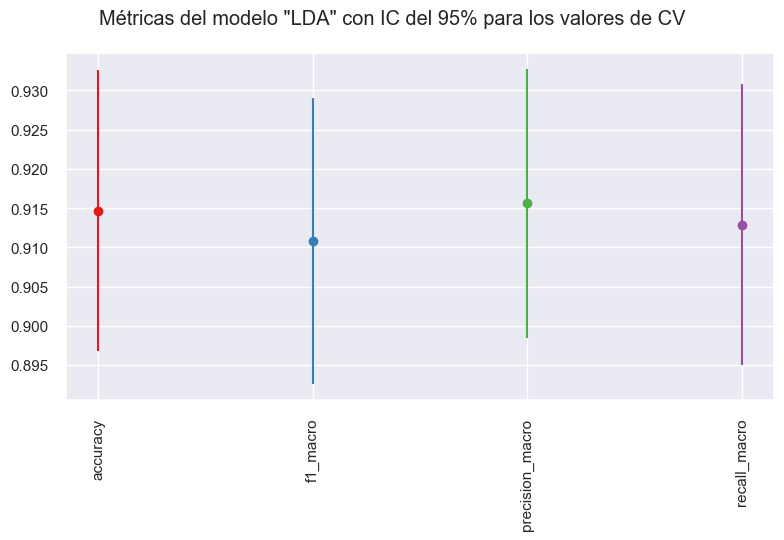

In [60]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()

lda.best_score_ = np.mean(cross_val_score(lda,X_train_scaled,y_train,cv=10))
print(lda.best_score_)

results = cross_validate(lda, X_train_scaled, y_train, cv=5, scoring=["accuracy", "f1_macro", "precision_macro", "recall_macro"])

show_results(results, "LDA")

El acierto del modelo ha mejorado muchisimo. Hemos pasado de 0.5 a 0.9 mas o menos en todas las metricas que estamos mirando.

Priors: [0.12863913 0.13608666 0.16587678 0.140826   0.15368991 0.13744076
 0.13744076]
Means:

Intercepts:
Explained Variance Ratio
Coefs:


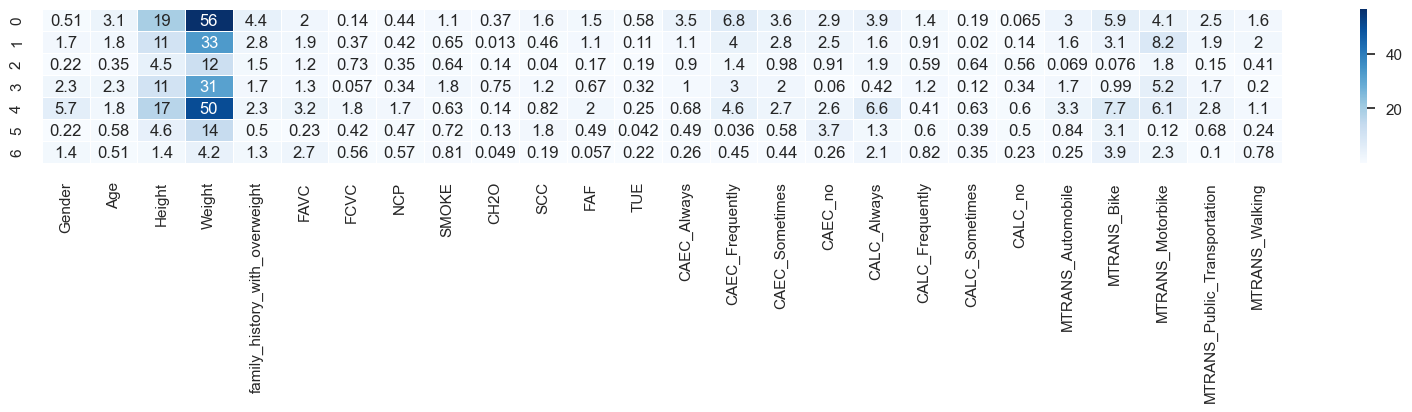

In [61]:
lda_model = LinearDiscriminantAnalysis().fit(X_train_scaled, y_train)

print('Priors:', lda_model.priors_)
print('Means:\n')
means =pd.DataFrame(lda_model.means_)
means.columns=X_train_scaled.columns
means

print('Intercepts:')
intercepts = pd.DataFrame(lda_model.intercept_)
intercepts

print('Explained Variance Ratio')
pd.DataFrame(lda_model.explained_variance_ratio_ )

print('Coefs:')
coefs = pd.DataFrame(lda_model.coef_)
coefs.columns = X_train_scaled.columns
# coefs.T

plt.figure(figsize=(20,2));
sns.heatmap(coefs.abs(),annot=True, linewidths=.5,cbar=True,xticklabels=True, cmap='Blues', annot_kws={'size':12});

Vemos que para el modelo el atributo más importante es el peso, cosa que parece razonable. Los otros atributos no tienenun coeficiente tan grande como el peso

In [62]:
print(classification_report(y_test, lda_model.predict(X_test_scaled)))

                     precision    recall  f1-score   support

Insufficient_Weight       0.92      1.00      0.96        82
      Normal_Weight       0.87      0.70      0.77        86
     Obesity_Type_I       0.95      0.92      0.93       106
    Obesity_Type_II       0.98      0.99      0.98        89
   Obesity_Type_III       1.00      1.00      1.00        97
 Overweight_Level_I       0.74      0.82      0.78        87
Overweight_Level_II       0.85      0.89      0.87        87

           accuracy                           0.90       634
          macro avg       0.90      0.90      0.90       634
       weighted avg       0.90      0.90      0.90       634



El acierto en el modelo parece coherente con lo que hemos obtenido en la validacion cruzada. Seguimos teniendo que la clase de obesidad de tipo 3 tiene el 100% de aciertos, pero esta vez el reto de las clases ha tenido unos resultados mucho mejores. En este caso las clases que menor precision tienen son el sobrepeso de nivel 1 y el peso normal.

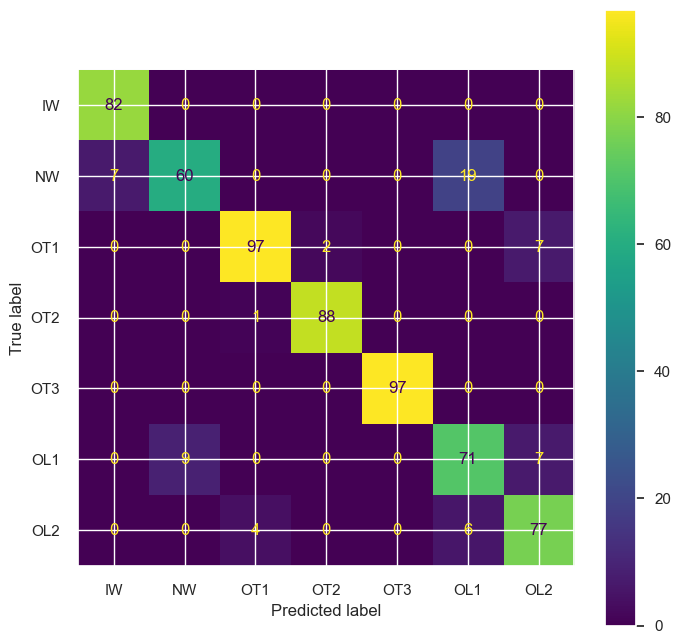

In [63]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lda_model, X_test_scaled,y_test, display_labels=labels, ax=plt.subplot());

Se ve claramente la mejora de resultados si comparamos las dos matrices de confusion entre el naive bayes y el dicriminante lineal. Como hemos dicho los resultados de la predicción del discriminante lineal son coherentes con los resultados que hemos obtenido en la validacion cruzada.

## APARTADO C

### REGRESION LOGISTICA


0.9634537598823314


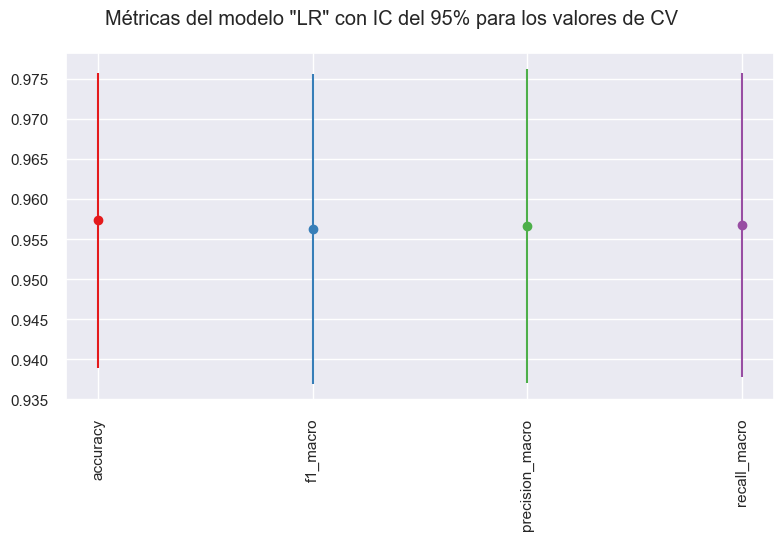

In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
show_html = lambda html: display(HTML(html))

lr= LogisticRegression(max_iter=10000)
param = {'penalty':['l1', 'l2'], 'C':10**np.linspace(-3,3,21, endpoint=True)}
lr_gs =  GridSearchCV(lr,param,cv=10, n_jobs=-1, refit=True)





lr_gs.best_score_ = np.mean(cross_val_score(lr_gs,X_train_scaled,y_train,cv=10))
print(lr_gs.best_score_)

results = cross_validate(lr_gs, X_train_scaled, y_train, cv=5, scoring=["accuracy", "f1_macro", "precision_macro", "recall_macro"])

show_results(results, "LR")

En este caso hemos vuelto ha mejorar los resultados respecto al modelo de discriminante lineal. Obtenemos valores entre 0.95 y 0.96, tanto en accuracy, como f1, como precision, como recall. Para optimizar lo mejor posible el modelo hemos usado GridSearch en busca de los mejores valores para los diferentes hiperparametros. Si a continuacion mostramos los mejores valroes para estos hiperparametros veremos que ha usado un valor C cercano a 501 i l2 como metrica penalty.

In [65]:
lr_gs.fit(X_train_scaled, y_train);
show_html(pd.DataFrame(lr_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html());

,params,mean_test_score,rank_test_score
39,"{'C': 501.18723362727246, 'penalty': 'l2'}",0.963,1
37,"{'C': 251.18864315095772, 'penalty': 'l2'}",0.961,2
35,"{'C': 125.89254117941663, 'penalty': 'l2'}",0.960,3
41,"{'C': 1000.0, 'penalty': 'l2'}",0.959,4
31,"{'C': 31.622776601683793, 'penalty': 'l2'}",0.955,5


A continuacion mostraremos los diferentes coeficientes de las varaibles para saber a cuales da más importancia cada clase.

Coefs:


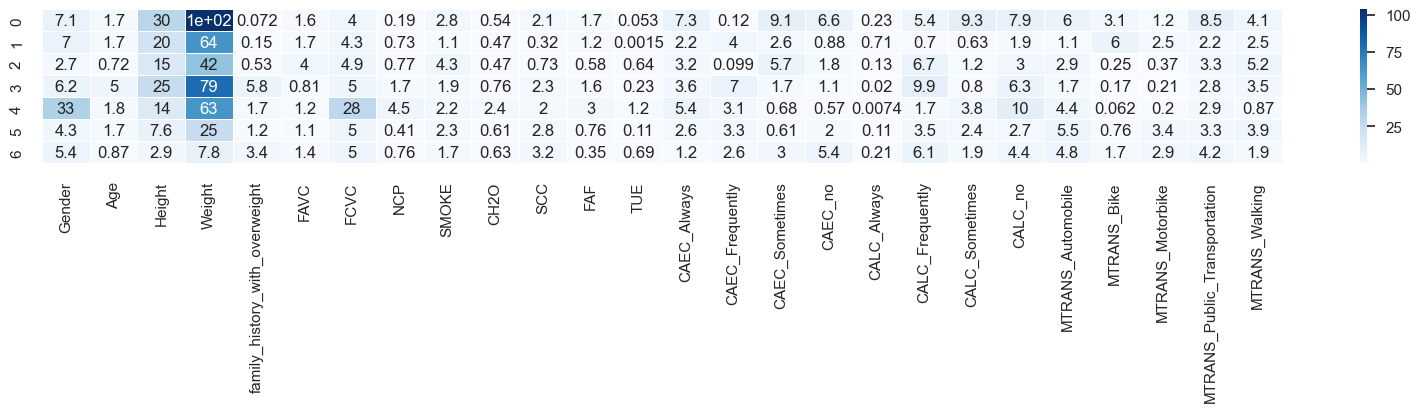

In [66]:
print('Coefs:')
coefs = pd.DataFrame(lr_gs.best_estimator_.coef_)
coefs.columns = X_train_scaled.columns

plt.figure(figsize=(20,2));
sns.heatmap(coefs.abs(),annot=True, linewidths=.5,cbar=True,xticklabels=True, cmap='Blues', annot_kws={'size':12});

Vemos que en general ocurre lo mismo que con el discriminante lineal. El atributo que tiene un peso mucho mayor que el resto en todas las clases es el peso. Vemos que en la clase 0, que corresponde a obesity type II, es la clase en la que el peso tiene un valor más grande de coeficiente respecto a las otras clases. Otro atributo con importancia podria ser la altura, que toma valores relativamente más grandes en todas las clases. Por otro lado tenemos que en la clase 4 que corresponde a Obesity type III el genero destaca respecto a las otras clases. Pasa lo mismo en el atributo FCVC que nos indica si nuestro usuario usualmente come verduras o no. El resto de los coeficientes de los atributos para el resto de clases no destacan sobre los demas. Vemos que el comportamiento es similar al del discriminante lineal, pero los coeficientes tienen valores mucho más altos en el caso de la regresion logistica

In [67]:
print(classification_report(y_test, lr_gs.predict(X_test_scaled)))

                     precision    recall  f1-score   support

Insufficient_Weight       0.96      0.99      0.98        82
      Normal_Weight       0.92      0.91      0.91        86
     Obesity_Type_I       0.96      0.92      0.94       106
    Obesity_Type_II       0.99      0.97      0.98        89
   Obesity_Type_III       0.97      0.99      0.98        97
 Overweight_Level_I       0.89      0.92      0.90        87
Overweight_Level_II       0.93      0.93      0.93        87

           accuracy                           0.95       634
          macro avg       0.95      0.95      0.95       634
       weighted avg       0.95      0.95      0.95       634



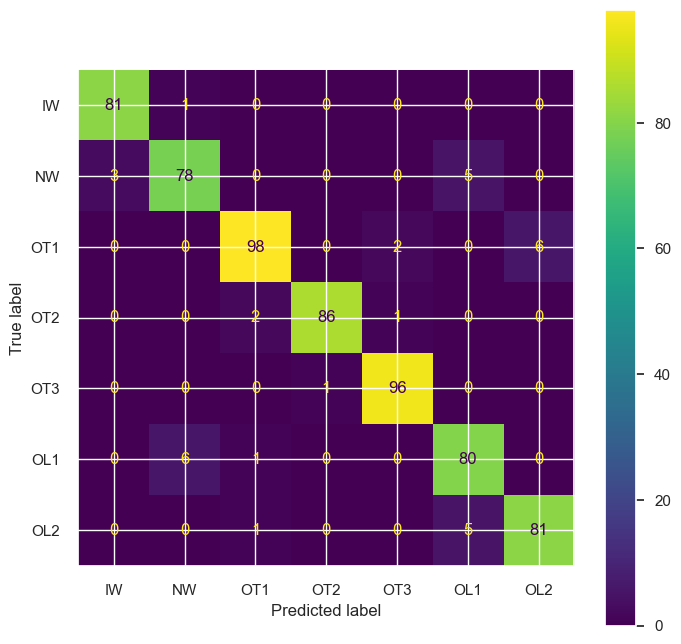

In [68]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lr_gs, X_test_scaled,y_test, display_labels=labels, ax=plt.subplot());

Una vez ejucutado el modelo con el conjunto de test vemos que los resultados siguen siendo muy positivos y coherentes con lo que hemos visto con el cross validation. Hemos mejorado considerablemente en la prediccion de todas las clases respecto a naive bayes y bastante tambien respecto al modelo de discriminacion lineal. En la matriz de confusion vemos que sigue habiendo algun fallo de predeccion entre el OL1 (overweight level 1) y OL2 (overweight level 2). Tambien tiene algun problema al predecir algunos individuos que irian clasificados como obesity type 1, ya que los reparte entre obesity type 3 y overweigth level 2. Por ultimo suele confundir algunas instancias entre normal weight i overweight level 1.

## APARTADO D

Por ultimo en este apartado entrenaremos y usaremos un modelo knn para ver si aumentamos la precision, aunque parece dificil dado los buenos resultados de la regresion logistica. Ademas como knn clasifica los valores segun los vecinos, hemos visto que nuestro pca no tenia las fronteras de las clases muy bien definidas cosa que podria dificultar la labor de knn. Aunque despues hemos visto que  TSNE conseguia mejorar la separabilidad de las clases aun habia algun cumulo donde se mezclaban dichas clases y donde las fronteras eran mas difusas.

### KNN

Primero ejecutaremos el modelo sin aplicar un reescalado de los datos. Más tarde ejecutaremos el modelo con el reescalado para que todos los datos esten entre [0,1].

### WITHOUT RESCALING

In [69]:

#scaler = MinMaxScaler()

#X_train_KNN = pd.DataFrame(scaler.fit_transform(X_train_scaled), columns=X_train_scaled.columns)
#X_test_KNN = pd.DataFrame(scaler.transform(X_test_scaled), columns=X_test_scaled.columns)

X_train_KNN = X_train_scaled
X_test_KNN = X_test_scaled



X_train_KNN.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,SMOKE,CH2O,...,CAEC_no,CALC_Always,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
90,0,0.440,-0.772,0.312,0,0,1.140,2.520,0,-1.655,...,0,0,0,0,1,0,0,0,1,0
513,0,-0.355,-1.107,-1.765,0,0,1.140,-1.346,0,0.692,...,0,0,0,0,1,0,0,0,1,0
1100,1,-0.981,-0.036,-0.262,1,0,-2.106,-0.497,0,0.702,...,0,0,0,1,0,0,0,0,1,0
339,0,-1.032,-1.811,-1.917,0,0,-0.873,0.302,0,-1.655,...,0,0,1,0,0,0,0,0,1,0
612,0,0.062,-1.244,-1.790,0,0,-0.518,-0.949,0,0.147,...,0,0,0,0,1,0,0,0,1,0


A continucacion trabajaremos con los datos de entrenamiento para poder ajustar los diferentes hiperparametros de knn y ver el resultado del modelo usando cross validation.

0.8841974627688913


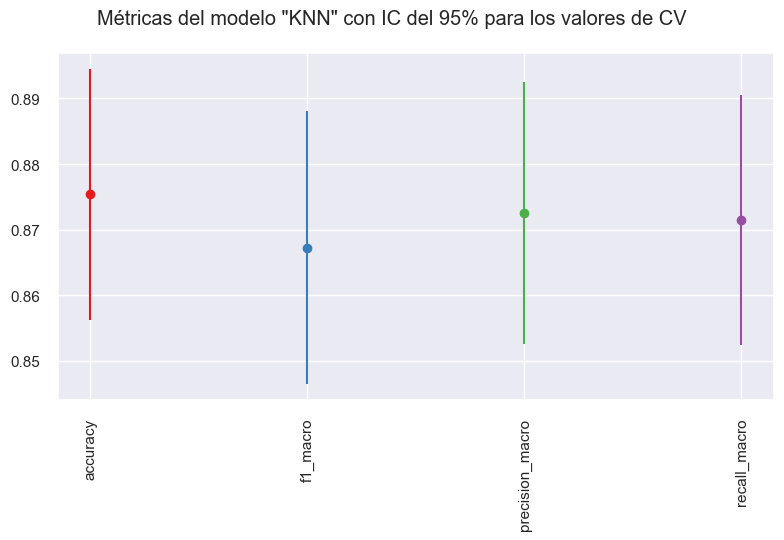

In [70]:
from sklearn.neighbors import KNeighborsClassifier


knn =  KNeighborsClassifier()
param = {'n_neighbors':[1, 3, 5, 7, 11, 15, 17, 19, 21], 
          'weights':['distance', 'uniform'], 
          'metric': ['l2', 'l1', 'cosine']}

knn_gs =  GridSearchCV(knn,param,cv=10, n_jobs=-1)

knn_gs.best_score_ = np.mean(cross_val_score(knn_gs,X_train_KNN,y_train,cv=10))
print(knn_gs.best_score_)

results = cross_validate(knn_gs, X_train_KNN, y_train, cv=5, scoring=["accuracy", "f1_macro", "precision_macro", "recall_macro"])

show_results(results, "KNN")


De primeras podemos decir que el rendimiento ha bajdo respecto a la regresion logistica. Estamos en resultados que se mueven en torno a valores entre [0.86, 0.88], cosa que son muy buenos reultados pero que hemos perdido casi 0.1 si comparamos con la regresion logistica.

Si nos fijamos en los hiperparametros que ha encontrado el grid search para nuestro modelo vemos que son los siguientes:
- Para la metrica de la distancia la mejor es l1
- El numero de vecinos se ha fijado en 3
- El peso se mide segun las distancias

Teniamos variaciones de los parametros que nos daban resultados muy similares como por ejemplo usando 5 vecinos en vez de 3

In [71]:
knn_gs.fit(X_train_KNN, y_train);
show_html(pd.DataFrame(knn_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html());

,params,mean_test_score,rank_test_score
20,"{'metric': 'l1', 'n_neighbors': 3, 'weights': 'distance'}",0.885,1
22,"{'metric': 'l1', 'n_neighbors': 5, 'weights': 'distance'}",0.882,2
18,"{'metric': 'l1', 'n_neighbors': 1, 'weights': 'distance'}",0.882,3
19,"{'metric': 'l1', 'n_neighbors': 1, 'weights': 'uniform'}",0.882,3
21,"{'metric': 'l1', 'n_neighbors': 3, 'weights': 'uniform'}",0.881,5


In [72]:
print(classification_report(y_test, knn_gs.predict(X_test_KNN)))

                     precision    recall  f1-score   support

Insufficient_Weight       0.94      0.96      0.95        82
      Normal_Weight       0.79      0.64      0.71        86
     Obesity_Type_I       0.85      0.94      0.90       106
    Obesity_Type_II       0.99      0.98      0.98        89
   Obesity_Type_III       0.99      1.00      0.99        97
 Overweight_Level_I       0.80      0.80      0.80        87
Overweight_Level_II       0.84      0.86      0.85        87

           accuracy                           0.89       634
          macro avg       0.89      0.88      0.88       634
       weighted avg       0.89      0.89      0.89       634



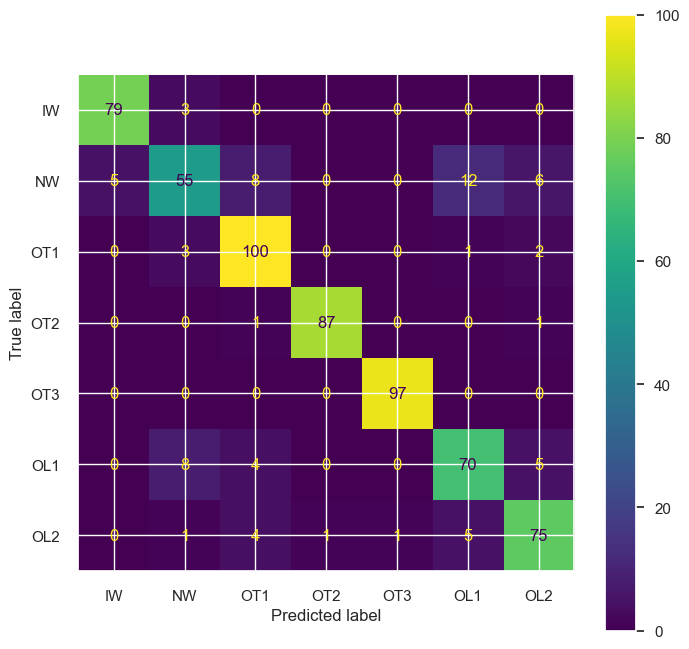

In [73]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(knn_gs, X_test_KNN,y_test, display_labels=labels, ax=plt.subplot());

Observando las matrices de confusion, donde probablemente más hemos perdido ha sido en la clase normal weight. Seguimos teniendo un gran acierto en la clase obesity type 3. Y en el resto de clases vemos que los errores se han repartido un como entre las diferentes clases. Esto puede deberse a que no hay una frontera clara entre ellas y knn encuentra vecinos de diferentes clases.

A continuacion ejecutaremos el modelo haciendo un reescalado para que los valores se situen entre [0,1], para que las distancias no influyan.

### WITH RESCALING

In [76]:

#scaler = MinMaxScaler()

X_train_KNN = pd.DataFrame(scaler.fit_transform(X_train_scaled), columns=X_train_scaled.columns)
X_test_KNN = pd.DataFrame(scaler.transform(X_test_scaled), columns=X_test_scaled.columns)

#X_train_KNN = X_train_scaled
#X_test_KNN = X_test_scaled



X_train_KNN.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,SMOKE,CH2O,...,CAEC_no,CALC_Always,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,-1.017,0.461,-0.774,0.299,-2.134,-2.728,1.158,2.761,-0.153,-1.625,...,-0.146,-0.026,-0.187,-1.398,1.513,-0.53,-0.052,-0.058,0.578,-0.16
1,-1.017,-0.333,-1.105,-1.739,-2.134,-2.728,1.158,-1.307,-0.153,0.684,...,-0.146,-0.026,-0.187,-1.398,1.513,-0.53,-0.052,-0.058,0.578,-0.16
2,0.983,-0.983,-0.042,-0.275,0.469,-2.728,-1.997,-0.530,-0.153,0.694,...,-0.146,-0.026,-0.187,0.715,-0.661,-0.53,-0.052,-0.058,0.578,-0.16
3,-1.017,-1.038,-1.800,-1.885,-2.134,-2.728,-0.884,0.261,-0.153,-1.625,...,-0.146,-0.026,5.342,-1.398,-0.661,-0.53,-0.052,-0.058,0.578,-0.16
4,-1.017,0.090,-1.241,-1.763,-2.134,-2.728,-0.549,-0.950,-0.153,0.128,...,-0.146,-0.026,-0.187,-1.398,1.513,-0.53,-0.052,-0.058,0.578,-0.16


0.863895017466446


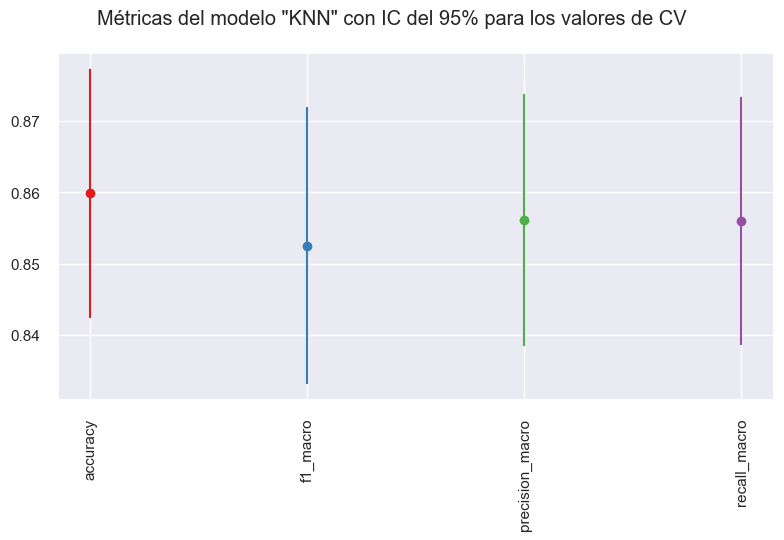

In [77]:
from sklearn.neighbors import KNeighborsClassifier


knn =  KNeighborsClassifier()
param = {'n_neighbors':[1, 3, 5, 7, 11, 15, 17, 19, 21], 
          'weights':['distance', 'uniform'], 
          'metric': ['l2', 'l1', 'cosine']}

knn_gs =  GridSearchCV(knn,param,cv=10, n_jobs=-1)

knn_gs.best_score_ = np.mean(cross_val_score(knn_gs,X_train_KNN,y_train,cv=10))
print(knn_gs.best_score_)

results = cross_validate(knn_gs, X_train_KNN, y_train, cv=5, scoring=["accuracy", "f1_macro", "precision_macro", "recall_macro"])

show_results(results, "KNN")


In [78]:
knn_gs.fit(X_train_KNN, y_train);
show_html(pd.DataFrame(knn_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html());

,params,mean_test_score,rank_test_score
20,"{'metric': 'l1', 'n_neighbors': 3, 'weights': 'distance'}",0.867,1
19,"{'metric': 'l1', 'n_neighbors': 1, 'weights': 'uniform'}",0.864,2
18,"{'metric': 'l1', 'n_neighbors': 1, 'weights': 'distance'}",0.864,2
21,"{'metric': 'l1', 'n_neighbors': 3, 'weights': 'uniform'}",0.860,4
24,"{'metric': 'l1', 'n_neighbors': 7, 'weights': 'distance'}",0.854,5


In [79]:
print(classification_report(y_test, knn_gs.predict(X_test_KNN)))

                     precision    recall  f1-score   support

Insufficient_Weight       0.84      0.94      0.89        82
      Normal_Weight       0.61      0.59      0.60        86
     Obesity_Type_I       0.82      0.92      0.87       106
    Obesity_Type_II       0.98      0.91      0.94        89
   Obesity_Type_III       0.99      0.99      0.99        97
 Overweight_Level_I       0.78      0.72      0.75        87
Overweight_Level_II       0.84      0.77      0.80        87

           accuracy                           0.84       634
          macro avg       0.84      0.83      0.83       634
       weighted avg       0.84      0.84      0.84       634



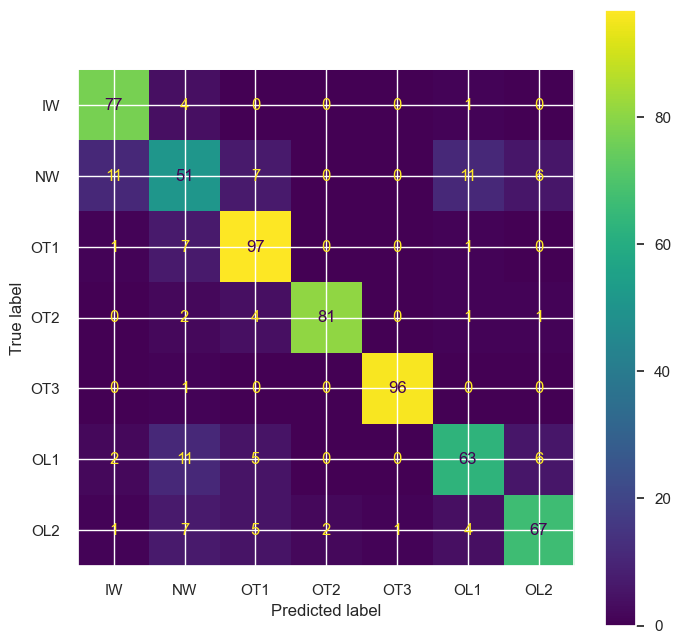

In [80]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(knn_gs, X_test_KNN,y_test, display_labels=labels, ax=plt.subplot());

En este caso hemos empeorado los resultados, han disminuido los valores de precision, recall, f1 de la clase normal weight que ahora predecimos peor que antes. Pero a niveles generales el accuracy no ha disminuido mucho. En conclusión no hemos mejorada los resultados haciendo un reescalado de nuestros datos.

### CONCLUSION

Como conclusiones podemos decir que el mejor modelo ha sido el de regresion logistica, luego vendria el de discriminante lineal, luego knn y por ultimo el naive bayes. Estos ressultados se puede deber a que por ejemplo naive bayes asume una distribución gausiana y nuestros datos no la siguen, con lo que los resultados no son optimos. Por otro lado como la regresion lineal no asume ninguna distribucion los resultados salen mejor ya que nuestros datos no siguen una distribucion aparente. Y por ultimo como knn utiliza las fronteras entre las clases para predecir el resultado y como hemos visto nuestras fronteras y la separabilidad de las clases no acababa de estar clara, pues su rendiemiento dismunuye respecto a la regresion logistica o al discriminante lineal. Asi que viendo los resultados podemos concluir que el mejor modelo que haria la mejor labor asignando un valor de la escala a nuevas personas seria la regresion logistica
